<a href="https://colab.research.google.com/github/atikhasan007/Computer-Vision/blob/main/image_classification_with_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
print("hello")

hello


In [4]:
!nvidia-smi

Fri Jan 30 14:11:40 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("osamajalilhassan/bone-fracture-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bone-fracture-dataset' dataset.
Path to dataset files: /kaggle/input/bone-fracture-dataset


In [6]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]
size = [224, 224] + [3]
size

[224, 224, 3]

In [22]:
train_path = '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/training'
valid_path = '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/testing'

In [10]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [11]:
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [13]:
for layer in vgg16.layers:
  print(layer.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [14]:
for layer in vgg16.layers:
  layer.trainable = False

In [15]:
for layer in vgg16.layers:
  print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [16]:
for layer in vgg16.layers:
  print(layer.name, layer.trainable)


input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [17]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [26]:
folders = glob("/kaggle/input/bone-fracture-dataset/BoneFractureDataset/training/*")
folders

['/kaggle/input/bone-fracture-dataset/BoneFractureDataset/training/not_fractured',
 '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/training/fractured']

In [27]:
num_of_class = len(folders)
num_of_class

2

In [29]:
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_of_class, activation='softmax'))

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [31]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [33]:
train_datagen = ImageDataGenerator(rescale =1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
)


test_datagen = ImageDataGenerator(rescale = 1./255)


In [34]:
training_set = train_datagen.flow_from_directory(
    train_path,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 8863 images belonging to 2 classes.


In [37]:
test_set = test_datagen.flow_from_directory(
    directory=valid_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

Found 600 images belonging to 2 classes.


In [38]:
r = model.fit(
    training_set,
    validation_data=test_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)

)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 174s 576ms/step - accuracy: 0.6613 - loss: 0.9698 - val_accuracy: 0.5250 - val_loss: 0.8991
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 150s 438ms/step - accuracy: 0.8993 - loss: 0.2662 - val_accuracy: 0.6467 - val_loss: 1.0583
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 140s 433ms/step - accuracy: 0.9473 - loss: 0.1527 - val_accuracy: 0.6800 - val_loss: 1.0623
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 124s 447ms/step - accuracy: 0.9612 - loss: 0.1071 - val_accuracy: 0.6417 - val_loss: 1.2697
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 119s 429ms/step - accuracy: 0.9621 - loss: 0.1046 - val_accuracy: 0.6617 - val_loss: 1.4009
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 119s 429ms/step - accuracy: 0.9809 - loss: 0.0556 - val_accuracy: 0.6817 - val_loss: 1.5019
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 121s 434ms/step - accuracy: 0.9804 - loss: 0.0565 - val_accuracy: 0.6433 - val_loss: 1.8276
Epoch 8/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 119s 430ms/step - accuracy: 0.9787 -

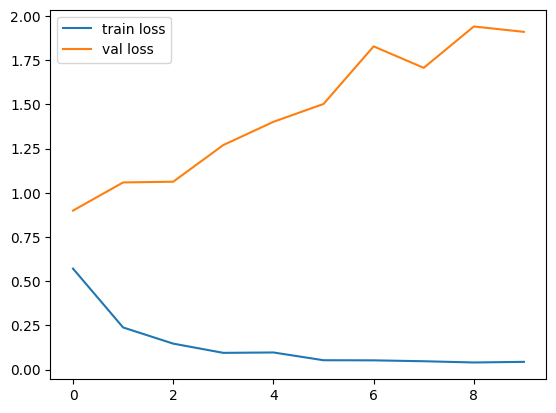

In [40]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

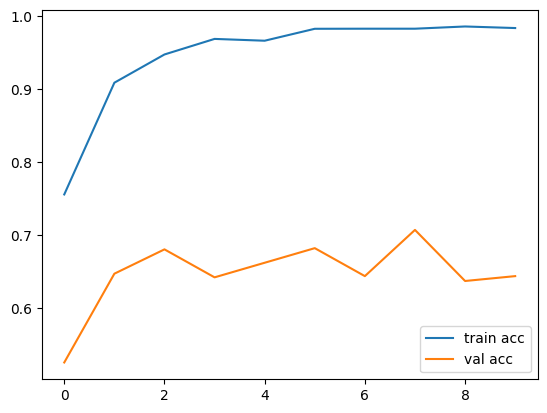

In [41]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [43]:
model.evaluate(test_set)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.6566 - loss: 1.8510


[1.909621000289917, 0.6433333158493042]

In [44]:
model.save('model_vgg16.h5')

In [45]:
from tensorflow.keras.preprocessing import image

In [ ]:
img = ""

In [ ]:
img = image.load_img(img, target_size=(224,224))
img

In [ ]:
x=image.img_to_array(img)
x

In [ ]:
z = plt.imread("")

In [ ]:
plt.imshow(z)

In [ ]:
x.shape

In [ ]:
x = x/225

In [ ]:
from keras.applications.vgg16 import preprocess_input
import numpy as np
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)




In [ ]:
output = model.predict(img_data)
output

In [ ]:
result = np.argmax(output, axis=1)
result


In [ ]:
if result[0] == 0:
  prediction = "Oblique fracture"
  print(prediction)
elif result[0] == 1:
  prediction = "spiral fracture"
  print(prediction)